### ***Initializing and Importing Packages***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import networkit as nk 
import networkx as nx
from igraph import *
import seaborn as sns

import Funcs

sns.color_palette("Set2")
sns.set_theme()
# For the image quality of the graphic. 
sns.set(rc={"figure.dpi":250})
# For the size of the graphics
sns.set(rc = {"figure.figsize":(4,2)})
sns.set(font_scale = 0.5)

DataDir = "../../Data/"
FigsDir = "../../Figs/"

symboles = [ 'ADA', 'BTC', 'ETH', 'SOL', 'XRP']


### ***Prepairing the Data*** 

In [2]:
Funcs.RepairData(DataDir, symboles)

#### ***Plotting the Returns*** 

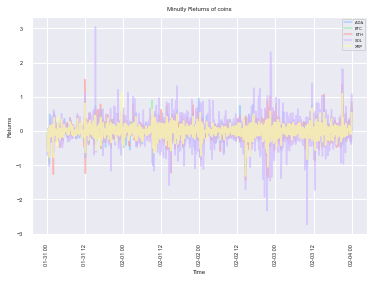

In [3]:
returns_df = Funcs.LoadData(DataDir, symboles)
plt.style.use('seaborn-pastel')
for sym in symboles:
    plt.plot(returns_df['time_close'], returns_df['%s' % sym], label = '%s' % sym, alpha = 0.7)

plt.title('Minutly Returns of coins')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.ylabel('Returns')
plt.legend(loc=1, prop={'size': 4})
plt.show()

### ***The Eddy-Fuller test***

In [4]:
Funcs.Eddy_Fuller_test(returns_df, symboles)

p-value (ADA) = 6.478327163602919e-30 
p-value (BTC) = 2.027917833467083e-30 
p-value (ETH) = 0.0 
p-value (SOL) = 0.0 
p-value (XRP) = 0.0 


### ***Optimum Lag***

In [5]:
Funcs.Optimum_lag(returns_df, symboles,24, 1, 3)

,AIC,BIC,FPE,HQIC
0,-7.563,-7.554*,0.0005194,-7.559*
1,-7.563,-7.537,0.0005191,-7.553
2,-7.564,-7.519,0.0005190,-7.547
3,-7.565,-7.502,0.0005184,-7.541
4,-7.569*,-7.488,0.0005164*,-7.538
5,-7.567,-7.469,0.0005172,-7.530
6,-7.563,-7.447,0.0005195,-7.519
7,-7.564,-7.430,0.0005187,-7.514
8,-7.564,-7.412,0.0005190,-7.506
9,-7.560,-7.391,0.0005207,-7.496


### ***Granger-Cause Test***

In [6]:
P_val_Dataframe, F_val_Dataframe = Funcs.grangers_causation_matrix(returns_df.iloc[:, 1:], variables=returns_df.columns[1:])


In [7]:
F_val_Dataframe #the dataframe consisting of the F scores for lag = 4

,ADA_x,BTC_x,ETH_x,SOL_x,XRP_x
ADA_y,0.0000,1.0954,0.9051,1.2617,0.1496
BTC_y,0.7462,0.0000,1.9240,2.0195,1.9373
ETH_y,1.1592,0.9390,-0.0000,1.2867,0.7963
SOL_y,2.0190,3.2705,1.1631,-0.0000,1.1003
XRP_y,0.4130,2.1360,1.0388,1.6284,0.0000


In [8]:
P_val_Dataframe #the dataframe consisting the minimum p-values

,ADA_x,BTC_x,ETH_x,SOL_x,XRP_x
ADA_y,1.0000,0.1140,0.2821,0.0857,0.7744
BTC_y,0.2052,1.0000,0.0681,0.0064,0.0132
ETH_y,0.1977,0.2373,1.0000,0.0655,0.2125
SOL_y,0.0425,0.0070,0.1488,1.0000,0.1050
XRP_y,0.6227,0.0143,0.1338,0.0751,1.0000


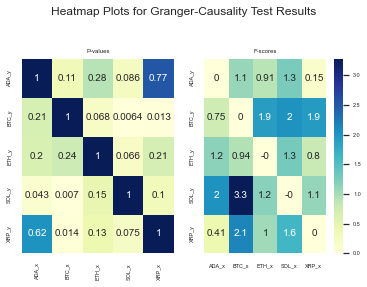

In [9]:
plt.subplot(1,2,2)
sns.heatmap(F_val_Dataframe, annot = True, cmap="YlGnBu")
plt.title('F-scores')

plt.subplot(1,2,1)
sns.heatmap(P_val_Dataframe, annot = True, cmap="YlGnBu" , cbar = False)
plt.title('P-values')
plt.xticks(rotation=90)

plt.suptitle('Heatmap Plots for Granger-Causality Test Results')
plt.subplots_adjust(top=0.8)

### ***Graph***

In [10]:
Matrix_ = Funcs.ScaleData(P_val_Dataframe)

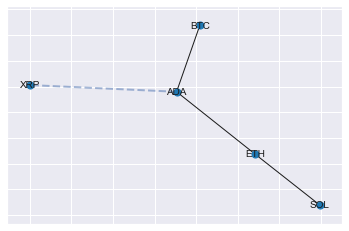

In [11]:
Funcs.MST_Graph(Matrix_, symboles)

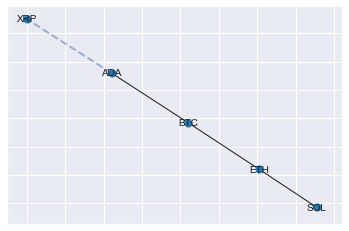

In [12]:
Matrix_ = np.array(F_val_Dataframe)
Funcs.MST_Graph(Matrix_, symboles)